In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, mutual_info_classif
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Hiperparametri eksperimenta

In [2]:
# PreviousAdmissionDays
PREV_ADM_DAYS_MEDIAN = 1055

# Height_Discharge
HEIGHT_MEDIAN_MALE = 176
HEIGHT_MEDIAN_FEMALE = 162
HEIGHT_MEDIAN_GENDER_MISSING = 172
HEIGHT_LOWER_LIM = 130
HEIGHT_UPPER_LIM = 204

# Weigth_Discharge
WEIGHT_MEDIAN_MALE = 90
WEIGHT_MEDIAN_FEMALE = 75
WEIGHT_MEDIAN_GENDER_MISSING = 85
WEIGHT_LOWER_LIM = 33
WEIGHT_UPPER_LIM = 199

# TODO: Dodati laurinu grupaciju za A-Z dijagnoze

GRUPE_LJEKOVA = {
  "Antibiotici": [
    "amoxicillin_count",
    "amoxicillin_and_betalactamase_inhibitor_count",
    "ampicillin_count",
    "ampicillin_and_betalactamase_inhibitor_count",
    "azithromycin_count",
    "cefalexin_count",
    "cefazolin_count",
    "cefepime_count",
    "ceftazidime_count",
    "ceftazidime_and_betalactamase_inhibitor_count",
    "ceftriaxone_count",
    "cefuroxime_count",
    "chloramphenicol_count",
    "ciprofloxacin_count",
    "clindamycin_count",
    "colistin_count",
    "erythromycin_count",
    "flucloxacillin_count",
    "gentamicin_count",
    "meropenem_count",
    "metronidazole_count",
    "moxifloxacin_count",
    "vancomycin_count"
  ],
  "Antikoagulanti": [
    "apixaban_count",
    "dabigatran_etexilate_count",
    "enoxaparin_count",
    "fondaparinux_count",
    "warfarin_count"
  ],

  "Antitrombotici": [
    "clopidogrel_count"
   ],

  "Antidijabetici": [
    "acarbose_count",
    "dapagliflozin_count",
    "empagliflozin_count",
    "gliclazide_count",
    "glimepiride_count",
    "insulin_aspart_count",
    "insulin_glargine_count",
    "insulin_human_count",
    "metformin_count",
    "metformin_and_alogliptin_count",
    "metformin_and_empagliflozin_count",
    "metformin_and_vildagliptin_count"
  ],
  "NSAID analgetici": [
    "diclofenac_count",
    "ibuprofen_count",
    "ketoprofen_count",
    "tramadol_and_paracetamol_count"

 ],
  "Opioidni analgetici": [
    "fentanyl_count",
    "morphine_count",
    "tramadol_count",
    "tramadol_and_paracetamol_count"
  ],
 "Antihipertenzivi": [
    "amlodipine_count",
    "diltiazem_count",
    "doxazosin_count",
    "losartan_count",
    "losartan_and_diuretics_count"
  ],
  "Beta blokatori": [
    "atenolol_count",
    "bisoprolol_count",
    "carvedilol_count",
    "metoprolol_count",
    "nebivolol_count"
  ],

 "ACE inhibitori": [
    "lisinopril_count",
    "perindopril_count",
    "ramipril_count"
 ],
  "Diuretici": [
    "furosemide_count",
    "spironolactone_count",
    "torasemide_count"
 ],
  "Statini": [
    "atorvastatin_count",
    "rosuvastatin_count"

  ],
  "Antipsihotici": [
    "haloperidol_count",
    "quetiapine_count",
    "risperidone_count"
  ],
  "Antiepileptici": [
    "carbamazepine_count",
    "lamotrigine_count",
    "levetiracetam_count",
    "valproic_acid_count" 
 ], 
  "Sedativi i anksiolitici": [
    "alprazolam_count",
    "bromazepam_count",
    "diazepam_count",
    "lorazepam_count",
    "midazolam_count",
    "zolpidem_count"
  ],
  "Antigiht": [
    "allopurinol_count",
    "colchicine_count"
 ],

  "Proton pump inhibitors": [
   "esomeprazole_count", 
   "pantoprazole_count"
 
  ],
  "Antihistaminici": [
    "loratadine_count"
  ],
  "Antiasmatici": [
    "aminophylline_count",
    "ipratropium_bromide_count",
    "salbutamol_count",
    "salbutamol_and_ipratropium_bromide_count"
  ],
  "Antiviralni": [
    "aciclovir_count",
    "oseltamivir_count"
  ],
  "Vitamini i Suplementi": [
    "colecalciferol_count"
  ],
  "Antiemetici": [
    "ondansetron_count"
 ],

 "Thyroid therapy": [
    "levothyroxine_sodium_count"
 
  ],
  "Antifungalni": [
    "fluconazole_count",
    "miconazole_count",
    "clotrimazole_count"
  ],
  "Antihipertenzivi": [
    "amlodipine_count",
    "doxazosin_count",
    "losartan_count",
    "losartan_and_diuretics_count"

  ],
  "Imunosupresivi": [
    "dexamethasone_count"
  ],
  "Kortikosteroidi": [
    "dexamethasone_count"
 ]
 
}


# Funkcije za ispravljanje dataset-a

In [3]:
df = pd.read_csv('../data/train.csv', index_col=0)
df_test = pd.read_csv('../data/test.csv', index_col=0)
all = pd.concat([df, df_test])

In [5]:
# Laurini ljekovi koji se ne pojavljuju u nasem datasetu
not_appearing = []
all_laura_ljek = []
for k, v in GRUPE_LJEKOVA.items():
    for ljek in v: 
        all_laura_ljek.append(ljek)
        if ljek not in all.columns: 
            not_appearing.append(ljek)
not_appearing

[]

In [ ]:
# Kolone iz naseg dataseta koje se ne pojavljuju u laurinim ljekovima
for l in all.columns[16:]:
    if l not in all_laura_ljek:
        print(l)

['doxycycline_count',
 'acetaminophen_count',
 'hydrochlorothiazide_count',
 'azathioprine_count'] -> ovi ljekovi iz laurinog .txt filea se ne pojavljuju u skupu podataka pa sam ih maknuo iz gornjeg dicta

In [7]:
age_groups_sorted = sorted(list(all.Age_Group.unique()))
age_group_numeric_mapping = {ag: i for i, ag in enumerate(age_groups_sorted)}
age_group_numeric_mapping

{'18-22': 0,
 '23-27': 1,
 '28-32': 2,
 '33-37': 3,
 '38-42': 4,
 '43-47': 5,
 '48-52': 6,
 '53-57': 7,
 '58-62': 8,
 '63-67': 9,
 '68-72': 10,
 '73-77': 11,
 '78-82': 12,
 '83-87': 13,
 '88-92': 14,
 '93-97': 15}

In [8]:
def fix_PreviousAdmissionDays(df):
    df['PrevAdmDaysAvail'] = (df.PreviousAdmissionDays > 0) * 1.0 # Valuable information for prediction
    df.loc[df.PreviousAdmissionDays == -8, 'PreviousAdmissionDays'] = PREV_ADM_DAYS_MEDIAN
    return df

def fix_Weigth_Discharge(df):
    gender_w_medians = {
        'Ž': WEIGHT_MEDIAN_FEMALE,
        'M': WEIGHT_MEDIAN_MALE,
        None: WEIGHT_MEDIAN_GENDER_MISSING
    }
    row_indexer = (df.Weight_Discharge < WEIGHT_LOWER_LIM) | (df.Weight_Discharge > WEIGHT_UPPER_LIM)
    df.loc[row_indexer, 'Weight_Discharge'] = df[row_indexer].Gender.map(gender_w_medians)
    return df

def fix_Heigth_Discharge(df):
    gender_h_medians = {
        'Ž': HEIGHT_MEDIAN_FEMALE,
        'M': HEIGHT_MEDIAN_MALE,
        None: HEIGHT_MEDIAN_GENDER_MISSING
    }
    row_indexer = (df.Height_Discharge < HEIGHT_LOWER_LIM) | (df.Height_Discharge > HEIGHT_UPPER_LIM)
    df.loc[row_indexer, 'Height_Discharge'] = df[row_indexer].Gender.map(gender_h_medians)
    return df

def aggregate_mediactions(df):
    to_drop = []
    for med_group, list_of_meds in GRUPE_LJEKOVA.items():
        df[f"{med_group}_count"] = df[list_of_meds].sum(axis=1)
        to_drop.extend(list_of_meds)
    df.drop(columns=to_drop, inplace=True)
    return df

def convert_age_groups_to_numeric(df):
    df['Age_Group'] = df.Age_Group.map(age_group_numeric_mapping)
    return df

def fix_dataset(df):
    df = fix_PreviousAdmissionDays(df)
    df = fix_Weigth_Discharge(df)
    df = fix_Heigth_Discharge(df)
    df = aggregate_mediactions(df)
    df = convert_age_groups_to_numeric(df)
    return df
    

In [9]:
all = fix_dataset(all)

In [10]:
all.shape

(35923, 206)

In [11]:
all.head()

AdmissionDx AdmissionType  PreviousAdmissionDays  LOS  Age_Group Gender  Surgery_Count  LOS_ICU  Discharge_Specialty Dx_Discharge Discharge_Status  Weight_Discharge  Height_Discharge                    Education Current_Work_Status  Label  acetylsalicylic_acid_count  albumin_count  alprostadil_count  amiodarone_count  atropine_count  b03aa07_count  benzathine_benzylpenicillin_count  betamethasone_count  butylscopolamine_count  calcium_chloride_count  carbohydrates_count  chlorhexidine_count  chloropyramine_count  clonazepam_count  coagulation_factor_ix_ii_vii_and_x_in_combination_count  coagulation_factor_viia_count  combinations_count  dexamethasone_and_antiinfectives_count  dexmedetomidine_count  diltiazem_count  dobutamine_count  electrolytes_count  epinephrine_count  eplerenone_count  escitalopram_count  etomidate_count  exemestane_count  ferric_oxide_polymaltose_complexes_count  ferrous_fumarate_count  flumazenil_count  folic_acid_count  fosfomycin_count  gliquidone_count  \
1           I     Elektivni                   1055    1         13      Ž              0        0              3010100            I             KUĆI              53.0             156.0       ZAVRŠENA OSNOVNA ŠKOLA            DOMAĆICA    0.0                           0              0                  0                 0               0              0                                  0                    0                       0                       0                    0                    0                     0                 0                                                  0                                    0                   0                                       0                      0                0                 0                   0                  0                 0                   0                0                 0                                         0                       0                 0                 0                 0                 0   
2           I     Elektivni                   1055   16         10      M              1        0              3100400            I             KUĆI              96.0             167.0    NEPOZNAT OBRAZOVNI STATUS        UMIROVLJENIK    0.0                           1              0                  0                 0               0              0                                  0                    0                       0                       1                    0                    0                     0                 0                                                  0                                    0                   0                                       0                      0                0                 0                   3                  0                 0                   0                0                 0                                         0                       0                 0                 0                 0                 0   
3           I     Elektivni                    279    3          0      Ž              1        0              3010100            I             KUĆI              52.0             163.0  ZAVRŠENO VISOKO OBRAZOVANJE             STUDENT    0.0                           0              0                  0                 0               1              0                                  0                    0                       0                       0                    0                    0                     0                 0                                                  0                                    0                   0                                       0                      0                0                 0                   1                  0                 0                   0                0                 0                                         0                       0                 0                 0                 0                 0   
4           I 

In [12]:
all.isna().sum()[all.isna().sum() > 0]

AdmissionDx              498
Gender                     2
Education                280
Current_Work_Status       50
Label                   7336
Probability_0          35923
Probability_1          35923
dtype: int64

Counts of missing values

# OneHot encoding and Scaling functions

In [13]:
def oneHot_encode_feature(df, feature):
    ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
    ohe.fit(df[df[feature].notnull()][[feature]])
    X = ohe.transform(df[[feature]])
    df[ohe.get_feature_names_out()] = X.toarray()
    df.drop(columns=[feature], inplace=True)
    return df

def scale_numeric_features(df, numeric_cols):
    scaler = StandardScaler()
    scaler.fit(df[numeric_cols])
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    return df

def encode_and_scale_features(df, enc_features, scale_features):
    for f in enc_features:
        df = oneHot_encode_feature(df, f)

    df = scale_numeric_features(df, scale_features)
    return df

# Obtaining Preprocessed dataset

In [14]:
cols_to_onehot_encode = [
    'AdmissionDx',
    'AdmissionType',
    'Gender',
    'Discharge_Specialty',
    'Dx_Discharge',
    'Discharge_Status',
    'Education',
    'Current_Work_Status'
]

cols_to_scale= [
    'PreviousAdmissionDays',
    'LOS',
    'Age_Group',
    'Surgery_Count',
    'LOS_ICU',
    'Weight_Discharge',
    'Height_Discharge'
]

In [15]:
df_train = pd.read_csv('../data/train.csv', index_col=0)
df_test = pd.read_csv('../data/test.csv', index_col=0)
df_train['Train'] = 1
df_test['Train'] = 0
all = pd.concat([df_train, df_test])

In [16]:
all = fix_dataset(all)
all = encode_and_scale_features(
    all,
    enc_features=cols_to_onehot_encode,
    scale_features=cols_to_scale
)

/Users/klabs/miniconda3/envs/kotaopy312/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/klabs/miniconda3/envs/kotaopy312/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/klabs/miniconda3/envs/kotaopy312/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/klabs/miniconda3/envs/kotaopy312/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.wa

In [17]:
all.head()

PreviousAdmissionDays       LOS  Age_Group  Surgery_Count   LOS_ICU  Weight_Discharge  Height_Discharge  Label  acetylsalicylic_acid_count  albumin_count  alprostadil_count  amiodarone_count  atropine_count  b03aa07_count  benzathine_benzylpenicillin_count  betamethasone_count  butylscopolamine_count  calcium_chloride_count  carbohydrates_count  chlorhexidine_count  chloropyramine_count  clonazepam_count  coagulation_factor_ix_ii_vii_and_x_in_combination_count  coagulation_factor_viia_count  combinations_count  dexamethasone_and_antiinfectives_count  dexmedetomidine_count  diltiazem_count  dobutamine_count  electrolytes_count  epinephrine_count  eplerenone_count  escitalopram_count  etomidate_count  exemestane_count  ferric_oxide_polymaltose_complexes_count  ferrous_fumarate_count  flumazenil_count  folic_acid_count  fosfomycin_count  gliquidone_count  glyceryl_trinitrate_count  heparin_count  hydrocortisone_count  indapamide_count  indometacin_count  iodixanol_count  \
1              -0.289586 -0.482977   1.692580      -0.458037 -0.050516         -2.007681         -1.644906    0.0                           0              0                  0                 0               0              0                                  0                    0                       0                       0                    0                    0                     0                 0                                                  0                                    0                   0                                       0                      0                0                 0                   0                  0                 0                   0                0                 0                                         0                       0                 0                 0                 0                 0                          0              0                     0                 0                  0                0   
2              -0.289586  1.883533   0.379549       1.910477 -0.050516          0.652788         -0.468054    0.0                           1              0                  0                 0               0              0                                  0                    0                       0                       1                    0                    0                     0                 0                                                  0                                    0                   0                                       0                      0                0                 0                   3                  0                 0                   0                0                 0                                         0                       0                 0                 0                 0                 0                          0              0                     0                 0                  0                0   
3              -0.800832 -0.167442  -3.997224       1.910477 -0.050516         -2.069552         -0.896000    0.0                           0              0                  0                 0               1              0                                  0                    0                       0                       0                    0                    0                     0                 0                                                  0                                    0                   0                                       0                      0                0                 0                   1                  0                 0                   0                0                 0                                         0                       0                 0                 0                 0                 0                          0              1                     0                 0                  0                0   
4               0.270413 -0.325210   1.692580      

In [18]:
df_train = all[all.Train == 1].copy()
df_test = all[all.Train == 0].copy()
df_train.drop(columns=['Train'], inplace=True)
df_train.drop(columns=['Probability_0'], inplace=True)
df_train.drop(columns=['Probability_1'], inplace=True)
df_test.drop(columns=['Train'], inplace=True)
df_test.drop(columns=['Probability_0'], inplace=True)
df_test.drop(columns=['Probability_1'], inplace=True)
df_test.drop(columns=['Label'], inplace=True)

In [19]:
df_train.shape

(28587, 257)

In [20]:
df_test.shape

(7336, 256)

In [21]:
feature_cols = list(df_train.columns)
feature_cols.remove('Label')

In [22]:
X_train = df_train[feature_cols].values
y_train = df_train['Label'].values
X_test = df_test[feature_cols].values

X_train, y_train, i X_test su numpy matrice spremne za uproabu sa sklearn library-om.

# Feature Selection

Na kraju ovog poglavlja trebamo imati X_train, y_train, X_test sa nebitnim kolonama izbačenim. Najočitije beskorisne feature se treba maknuti sa variance thresholdima, ostalim metodama itd., i onda izvrtiti backward wrapper feature selection sa lightweight RandomForestom, ili L1 log.reg. ako se RF pokaže da je jednostavno prespor. 

## Lasso

In [21]:
print(X_train.shape)

(28587, 256)


In [23]:
# Set the regularization parameter C=1
logistic = LogisticRegression(C=0.6, penalty='l1', class_weight='balanced', solver='liblinear', random_state=42).fit(X_train, y_train)
f_selector = SelectFromModel(logistic, prefit=True, threshold=1e-3)

X_train_new = f_selector.transform(X_train)
print(X_train_new.shape)

(28587, 202)


In [24]:
l1_coefs = pd.DataFrame({'feature': feature_cols, 'L1_coef': logistic.coef_[0]})

In [25]:
len(l1_coefs[l1_coefs.L1_coef.abs() < 1e-3])

54

In [26]:
l1_coefs[l1_coefs.L1_coef.abs() < 1e-3]

feature  L1_coef
9                                    alprostadil_count      0.0
12                                       b03aa07_count      0.0
13                   benzathine_benzylpenicillin_count      0.0
15                              butylscopolamine_count      0.0
20                                    clonazepam_count      0.0
24              dexamethasone_and_antiinfectives_count      0.0
25                               dexmedetomidine_count      0.0
26                                     diltiazem_count      0.0
33                                    exemestane_count      0.0
35                              ferrous_fumarate_count      0.0
36                                    flumazenil_count      0.0
61                         macrogol_combinations_count      0.0
63                                     memantine_count      0.0
71                                    mometasone_count      0.0
72                                   montelukast_count      0.0
79                                   neostigmine_count      0.0
81                                nitrofurantoin_count      0.0
84                                    octreotide_count      0.0
89                                    paroxetine_count      0.0
94                                 phenobarbital_count      0.0
115                   rosuvastatin_and_ezetimibe_count      0.0
118                                   sertraline_count      0.0
121                                  sitagliptin_count      0.0
123                                   sufentanil_count      0.0
124            sulfamethoxazole_and_trimethoprim_count      0.0
127                   tamsulosin_and_dutasteride_count      0.0
129                                   thiamazole_count      0.0
137                              tranexamic_acid_count      0.0
144                                  venlafaxine_count      0.0
149                                                  B      0.0
163                                                  R      0.0
166                                                  U      0.0
170                                  Antibiotici_count      0.0
189                        Vitamini i Suplementi_count      0.0
195                                      AdmissionDx_B      0.0
196                                      AdmissionDx_C      0.0
199                                      AdmissionDx_F      0.0
201                                      AdmissionDx_H      0.0
207                                      AdmissionDx_N      0.0
212                                      AdmissionDx_Y      0.0
219                        Discharge_Specialty_3190100      0.0
221                                     Dx_Discharge_C      0.0
225                                     Dx_Discharge_H      0.0
228                                     Dx_Discharge_K      0.0
229                                     Dx_Discharge_L      0.0
232                                     Dx_Discharge_R      0.0
234                                     Dx_Discharge_Z      0.0
236  Discharge_Status_LIJEČENJE OKONČANO PROTIVNO S...      0.0
239             Discharge_Status_UMRO (NIJE OBDUCIRAN)      0.0
241              Education_NIJE POHAĐALA OSNOVNU ŠKOLU      0.0
242              Education_NIJE ZAVRŠILA OSNOVNU ŠKOLU      0.0
251                  Current_Work_Status_REDOVAN POSAO      0.0
253                        Current_Work_Status_STUDENT      0.0
255                         Current_Work_Status_UČENIK      0.0

In [27]:
l1_coefs[l1_coefs.L1_coef.abs() > 1e-3]

feature   L1_coef
0                                PreviousAdmissionDays -0.005207
1                                                  LOS  0.067243
2                                            Age_Group  0.047630
3                                        Surgery_Count -0.299877
4                                              LOS_ICU  0.001049
5                                     Weight_Discharge -0.022540
6                                     Height_Discharge  0.130617
7                           acetylsalicylic_acid_count  0.200447
8                                        albumin_count -0.265704
10                                    amiodarone_count  0.001105
11                                      atropine_count  0.067129
14                                 betamethasone_count  0.986273
16                              calcium_chloride_count -0.490149
17                                 carbohydrates_count -0.019754
18                                 chlorhexidine_count -0.166848
19                                chloropyramine_count  0.065948
21   coagulation_factor_ix_ii_vii_and_x_in_combinat... -1.441323
22                       coagulation_factor_viia_count  0.700491
23                                  combinations_count  0.497927
27                                    dobutamine_count  0.286012
28                                  electrolytes_count  0.010650
29                                   epinephrine_count  0.174717
30                                    eplerenone_count  0.049733
31                                  escitalopram_count  0.334286
32                                     etomidate_count  0.193961
34            ferric_oxide_polymaltose_complexes_count -0.768241
37                                    folic_acid_count  0.110985
38                                    fosfomycin_count  1.039374
39                                    gliquidone_count -1.442903
40                           glyceryl_trinitrate_count  0.929334
41                                       heparin_count -0.004069
42                                hydrocortisone_count -0.072069
43                                    indapamide_count  0.016089
44                                   indometacin_count -0.541960
45                                     iodixanol_count  0.036527
46                                       iohexol_count -0.113638
47                          isosorbide_dinitrate_count -0.051403
48                        isosorbide_mononitrate_count  0.041482
49                                    ivabradine_count -0.200562
50                                      ketamine_count -0.725755
51                                    lacidipine_count -0.912969
52                                     lactulose_count  0.209351
53                                 lercanidipine_count -0.292621
54                               levobupivacaine_count -2.540892
55          levodopa_and_decarboxylase_inhibitor_count -0.350818
56                                  levofloxacin_count -0.651100
57                                     lidocaine_count  0.160592
58                                   linagliptin_count  1.116875
59                                     linezolid_count  0.456738
60                                    loperamide_count  0.022483
62                                      mannitol_count -0.484043
64                                    mesalazine_count -1.433129
65                             metamizole_sodium_count -0.347610
66                           methylphenobarbital_count -0.438241
67                            methylprednisolone_count -0.403476
68                                  metildigoxin_count  0.103830
69                                metoclopramide_count -0.226094
70                                   mirtazapine_count -0.231060
73                                    moxonidine_count -0.059619
74                                     mupirocin_count -0.118563
75                                       n02bf01_count -2.562414
76               

In [28]:
df_train['Label'] = y_train

In [29]:
df_train.dobutamine_count.value_counts()

dobutamine_count
0    26105
1     2482
Name: count, dtype: int64

In [30]:
df_train[['dobutamine_count', 'Label']].groupby('dobutamine_count').value_counts()

dobutamine_count  Label
0                 0.0      24364
                  1.0       1741
1                 0.0       2333
                  1.0        149
Name: count, dtype: int64

In [31]:
matthews_corrcoef(y_train, logistic.predict(X_train))

0.2934977993777775

In [32]:
logistic.predict(X_train).mean()

0.36478119424913424

L1 feature selection might be an option...

## Variance filter methods

We can use this method to get rid of monotone features

In [33]:
v_threshold = VarianceThreshold(threshold=0.001)
v_threshold.fit(X_train)
meets_var_thresholds = pd.DataFrame({'feature': feature_cols, 'passes_var': v_threshold.get_support()})

In [34]:
meets_var_thresholds.passes_var.mean()

0.7421875

In [35]:
meets_var_thresholds[~meets_var_thresholds.passes_var]

feature  passes_var
9                                    alprostadil_count       False
12                                       b03aa07_count       False
13                   benzathine_benzylpenicillin_count       False
14                                 betamethasone_count       False
15                              butylscopolamine_count       False
20                                    clonazepam_count       False
22                       coagulation_factor_viia_count       False
25                               dexmedetomidine_count       False
26                                     diltiazem_count       False
31                                  escitalopram_count       False
33                                    exemestane_count       False
35                              ferrous_fumarate_count       False
38                                    fosfomycin_count       False
49                                    ivabradine_count       False
55          levodopa_and_decarboxylase_inhibitor_count       False
56                                  levofloxacin_count       False
59                                     linezolid_count       False
61                         macrogol_combinations_count       False
63                                     memantine_count       False
64                                    mesalazine_count       False
66                           methylphenobarbital_count       False
70                                   mirtazapine_count       False
71                                    mometasone_count       False
72                                   montelukast_count       False
76                                       n02bf02_count       False
84                                    octreotide_count       False
89                                    paroxetine_count       False
94                                 phenobarbital_count       False
100                                    prasugrel_count       False
115                   rosuvastatin_and_ezetimibe_count       False
116                                   salmeterol_count       False
118                                   sertraline_count       False
121                                  sitagliptin_count       False
125                                    sulpiride_count       False
127                   tamsulosin_and_dutasteride_count       False
129                                   thiamazole_count       False
134                           tiotropium_bromide_count       False
144                                  venlafaxine_count       False
166                                                  U       False
167                                                  Y       False
188                                  Antiviralni_count       False
189                        Vitamini i Suplementi_count       False
195                                      AdmissionDx_B       False
196                                      AdmissionDx_C       False
199                                      AdmissionDx_F       False
201                                      AdmissionDx_H       False
204                                      AdmissionDx_K       False
205                                      AdmissionDx_L       False
206                                      AdmissionDx_M       False
207                                      AdmissionDx_N       False
210                                      AdmissionDx_S       False
211                                      AdmissionDx_T       False
212                                      AdmissionDx_Y       False
221                                     Dx_Discharge_C       False
223                                     Dx_Discharge_E       False
224                                     Dx_Discharge_G       False
225                                     Dx_Discharge_H       False
228                                     Dx_Discharge_K       False
229                                     Dx_Discharge_L       False
230                        

In [36]:
df_test.sitagliptin_count.value_counts()

sitagliptin_count
0    7304
1      32
Name: count, dtype: int64

In [37]:
df_train[['sitagliptin_count', 'Label']].groupby('sitagliptin_count').value_counts(normalize=True)

sitagliptin_count  Label
0                  0.0      0.933856
                   1.0      0.066144
1                  0.0      1.000000
Name: proportion, dtype: float64

## Information Gain

In [ ]:
importances = mutual_info_classif(X_train, y_train)

In [100]:
mutual_info = pd.DataFrame({'feature': feature_cols, 'IG': importances})

<Axes: >

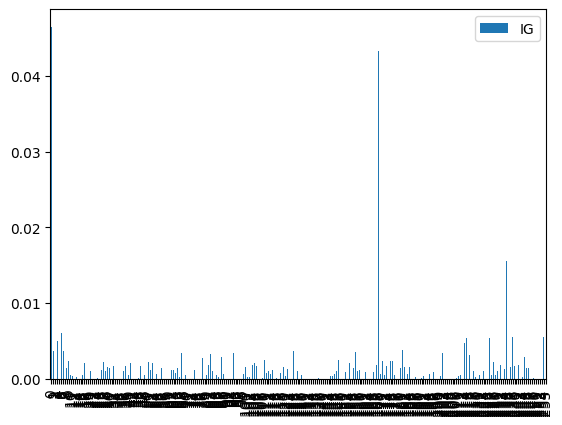

In [102]:
mutual_info.plot(kind='bar')

In [107]:
mutual_info[mutual_info.IG > 0.001]

feature        IG
0                                PreviousAdmissionDays  0.046490
1                                                  LOS  0.003586
3                                        Surgery_Count  0.005007
5                                     Weight_Discharge  0.006059
6                                     Height_Discharge  0.003663
8                                        albumin_count  0.001347
9                                    alprostadil_count  0.002354
17                                 carbohydrates_count  0.002099
20                                    clonazepam_count  0.001004
26                                     diltiazem_count  0.001121
27                                    dobutamine_count  0.002141
28                                  electrolytes_count  0.001072
29                                   epinephrine_count  0.001518
30                                    eplerenone_count  0.001414
32                                     etomidate_count  0.001679
37                                    folic_acid_count  0.001074
38                                    fosfomycin_count  0.001636
39                                    gliquidone_count  0.001367
41                                       heparin_count  0.002014
46                                       iohexol_count  0.001611
50                                      ketamine_count  0.002186
51                                    lacidipine_count  0.001089
52                                     lactulose_count  0.002031
57                                     lidocaine_count  0.001413
62                                      mannitol_count  0.001134
63                                     memantine_count  0.001209
65                             metamizole_sodium_count  0.001412
67                            methylprednisolone_count  0.003327
74                                     mupirocin_count  0.001170
78                                      naloxone_count  0.002683
81                                nitrofurantoin_count  0.001809
82                                norepinephrine_count  0.003301
83                                   norfloxacin_count  0.001006
88                                   paracetamol_count  0.002852
94                                 phenobarbital_count  0.003390
100                                    prasugrel_count  0.001565
104                                     propofol_count  0.001810
105                                    protamine_count  0.002054
106                                  rabeprazole_count  0.001606
110                                   ranolazine_count  0.002526
112                                   rifampicin_count  0.001057
114                           rocuronium_bromide_count  0.001102
120                          silver_sulfadiazine_count  0.001547
122                                      sotalol_count  0.001225
125                                    sulpiride_count  0.003598
135                                   tobramycin_count  0.003486
148                                                  A  0.002526
151                                                  D  0.002118
154                                                  G  0.002002
156                                                  I  0.001371
157                                                  J  0.003506
159                                                  L  0.001087
167                                                  Y  0.001960
168                                                  Z  0.001797
169                                   PrevAdmDaysAvail  0.043296
171                               Antikoagulanti_count  0.002381
173                               Antidijabetici_count  0.001725
175                          Opioidni analgetici_count  0.002274
176                             Antihipertenzivi_count  0.002271
180                                      Statini_count  0.001470
181                                Antipsihotici_count  0.003776
182              

In [108]:
df_train[['A', 'Label']].groupby('A').value_counts(normalize=True)

A  Label
0  0.0      0.933817
   1.0      0.066183
1  0.0      0.977273
   1.0      0.022727
2  0.0      1.000000
Name: proportion, dtype: float64

In [110]:
df_train[['A', 'Label']].groupby('A').value_counts()

A  Label
0  0.0      26653
   1.0       1889
1  0.0         43
   1.0          1
2  0.0          1
Name: count, dtype: int64

## Wrapper methods

In [118]:
clf = RandomForestClassifier(n_estimators=200, min_samples_split=9, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=9, n_estimators=200, random_state=42)

In [119]:
y_pred = clf.predict(X_train)

In [120]:
matthews_corrcoef(y_train, y_pred)

0.5759821252389372

In [121]:
(y_pred == y_train).mean()

0.956833525728478

In [122]:
y_pred.mean()

0.02294749361597929

Text(50.722222222222214, 0.5, 'True Label')

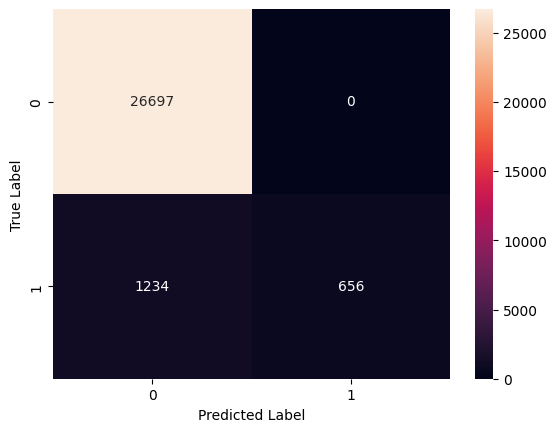

In [124]:
cfm=confusion_matrix(y_train, y_pred)
ax = sns.heatmap(cfm, annot=True, fmt='d')

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

In [38]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [40]:
# Kao sto se vidi ispod ovaj model bi mogli koristiti za backward wrapper method feature selection....
clf = RandomForestClassifier(n_estimators=200, min_samples_split=40, class_weight='balanced', oob_score=matthews_corrcoef, random_state=42)
clf.fit(X2_train, y2_train)
clf.oob_score_

0.3219220152912914

In [43]:
y2_pred = clf.predict(X2_test)
matthews_corrcoef(y2_test, y2_pred)

0.30120787542567296

In [44]:
y2_pred.mean()

0.09667161331354675

Text(50.722222222222214, 0.5, 'True Label')

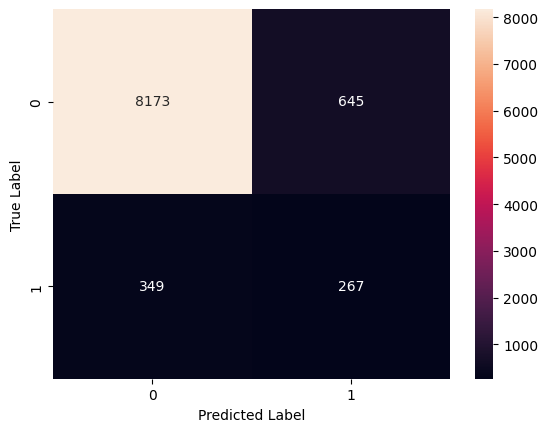

In [46]:
cfm=confusion_matrix(y2_test, y2_pred)
ax = sns.heatmap(cfm, annot=True, fmt='d')

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

In [ ]:
estimator = RandomForestClassifier(n_estimators=200, min_samples_split=40, class_weight='balanced', random_state=42)
sfs = SequentialFeatureSelector(estimator, tol=-0.001, direction="backward", scoring=matthews_corrcoef)
sfs.fit(X_train, y_train)
wrapper_results = pd.DataFrame({'features': feature_cols, 'selected': sfs.get_support()})

Moramo dosta srezati poceti skup featurea prije nego sto ovo provertimo. Mozemo maknuti najocitije beskorisne feature iz svih proslih metoda (tipa variance threshold) i onda ovo izvrtit.

In [ ]:
wrapper_results[wrapper_results.selected]

In [26]:
# MCC score if we just predict based on whether prev admission days was -8 or not
matthews_corrcoef(y_train, df_train.PrevAdmDaysAvail == 0)

0.2588854238759656

Dakle najgluplji model kojeg mozemo smislit ima mcc 0.258.

# Model Selection

Jednom kada imamo X_train, i y_train sa nebitnim kolonama ukonjenima treba izvršiti stratified k-fold cross validation grid search hiperparametra za sve klasicne modele (log.reg., SVM, RandomForest, GradientBoostingClassifier, xgboost.XGBClassifier). Scoring metrika za cross validaciju treba biti mcc. Rezultat ovog poglavlja je izbor modela i njegovih hiperparametara koje ćemo koristiti za finalno rješenje.

Kros validaciju s ovim napravit: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html


Grid search + Cross validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Test Set Prediction

U ovom poglavlju treba izgenerirati finalni model s hiperparametrima izabranim u Model Selection poglavlju nad čitavim train datasetom (s nebitnim featurima maknutima naravno). Ne trebamo hold-out test set. Generirati predikcije za test set u traženom formatu. Upload-ati ih na ai4health stranicu i cekat da vidimo jel prodemo u drugi krug :)